In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

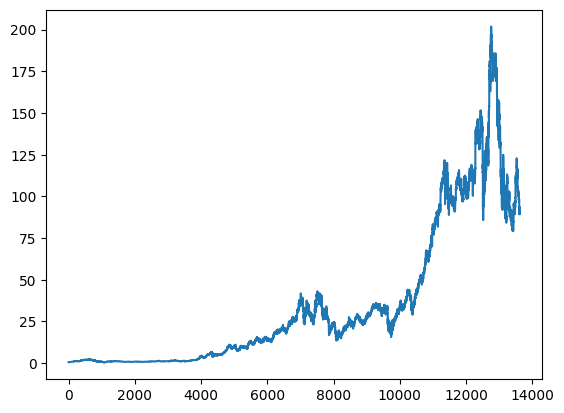

In [2]:
df = pd.read_csv('DIS.csv')
dataset = df['Close'].values.reshape(-1,1)
dataset = dataset.astype('float32')
plt.plot(dataset)

In [3]:
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6808 6809


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_dataset(dataset, lookback): 
    X, y = [], []
    for i in range(len(dataset) - lookback): 
        feature = dataset[i:i+lookback]
        # target = dataset[i+1:i+lookback+1]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)

In [16]:
lookback = 240
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test = TensorDataset(X_test, y_test)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

ValueError: only one element tensors can be converted to Python scalars

In [53]:
# for i in range(3): 
#     plt.figure()
#     plt.plot(timeseries[:10])
#     plt.plot(range(i, i+lookback), X_train[i].numpy(), 'ro')
#     plt.plot(range(i+1, i+lookback+1), y_train[i].numpy(), 'bx')
#     plt.show()

In [8]:
class LSTMModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm = nn.LSTM(1, 200, batch_first=True)
        self.linear = nn.Linear(200, 1)

    def forward(self, x): 
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x


In [75]:
lstm = nn.LSTM(1, 200, batch_first=True)
fc = nn.Linear(200, 1)

input = torch.randn(32, 240, 1)

out, (h, c) = lstm(input)
out2 = fc(out[:, -1, :])
print(out.shape, h.shape, c.shape, out2.shape)


torch.Size([32, 240, 200]) torch.Size([1, 32, 200]) torch.Size([1, 32, 200]) torch.Size([32, 1])


In [9]:
model = LSTMModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


In [50]:
for f, t in train_loader: 
    print(f.shape, t.shape)
    break

model(f).shape

torch.Size([64, 240, 1]) torch.Size([64, 1])


torch.Size([64, 1])

In [11]:
n_epochs = 100
for epoch in range(n_epochs): 
    model.train()
    for X_batch, y_batch in train_loader: 
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 != 0: 
        continue

    model.eval()
    with torch.no_grad(): 
        test_loss = 0
        for X_batch, y_batch in test_loader: 
            y_pred = model(X_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
        print(f"Epoch {epoch} Test loss: {test_loss/len(test_loader)}")


Epoch 0 Test loss: 3764.8789707187525
Epoch 10 Test loss: 3572.661410184125
Epoch 20 Test loss: 3391.7206799449777
Epoch 30 Test loss: 3306.508428344214
Epoch 40 Test loss: 3256.6269097077543
Epoch 50 Test loss: 3240.431727927974
Epoch 60 Test loss: 3210.934620360799
Epoch 70 Test loss: 3198.7700109809675
Epoch 80 Test loss: 3222.6733474143357
Epoch 90 Test loss: 3231.3599094451015


torch.Size([8, 240, 1])

torch.Size([6568, 240, 1])

In [24]:
# with torch.no_grad(): 
#     train_plot = np.ones_like(timeseries) * np.nan
#     y_pred = model(X_train)
#     y_pred = y_pred[:, -1, :]
#     train_plot[lookback:train_size] = model(X_train)[:, -1, :]
#     test_plot = np.ones_like(timeseries) * np.nan
#     test_plot[train_size+lookback:] = model(X_test)[:, -1, :]

# plt.plot(timeseries, label='Original', color='black')
# plt.plot(train_plot, label='Train', color='blue')
# plt.plot(test_plot, label='Test', color='red')

import plotly.graph_objects as go
import plotly.express as px


with torch.no_grad(): 
    train_plot = np.ones_like(dataset) * np.nan
    y_pred = model(X_train)
    train_plot[lookback:train_size] = y_pred.cpu().numpy()
    test_plot = np.ones_like(dataset) * np.nan
    test_plot[train_size+lookback:] = model(X_test).cpu().numpy()
    # px.line(y=y_pred.cpu().numpy().flatten())
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=dataset.flatten(), mode='lines', name='Original'))
    fig.add_trace(go.Scatter(y=train_plot.flatten(), mode='lines', name='Train'))
    fig.add_trace(go.Scatter(y=test_plot.flatten(), mode='lines', name='Test'))
    # fig.show()

In [28]:
fig.write_html("figure.html")
